In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import os
import folium
import folium.plugins as plugins
from folium.features import DivIcon
from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
import matplotlib.pyplot as plt


%store -r file_name

met_data = pd.read_csv(file_name)
station_data = pd.read_csv('station_info.csv').rename(columns={'id':'station'})

merged_data = pd.merge(met_data, station_data, on='station')
# calculate the dewpoint and add the dataframe
td = dewpoint_from_relative_humidity(merged_data['tl'].values * units.degC, merged_data['rf'].values * units.percent)

merged_data['td'] = td.magnitude.round(decimals=1)
merged_data['ffxkmh'] = (merged_data['ffx'] * 3.6).round(decimals=1)
merged_data['time'] = pd.to_datetime(merged_data['time'])

# extract = merged_data[merged_data['name'].str.contains(r'Mariazell|Lilienfeld|St.P')][['tl','time','name', 'lat', 'lon']]
extract = merged_data[['tl','tlmax','td','dd', 'time','ffxkmh', 'ddx', 'name', 'lat', 'lon']]


# # Plot the responses for different events and regions
# sns.lineplot(x="time", y="tl",
#              hue="name",
#              data=extract)

# sns.despine()



In [2]:
extract.loc[extract['time'] == extract['time'].iloc[-4]].dropna()

# This creates the times that are in the csv file
indexed = extract.set_index('time').drop_duplicates()
individual_dates = indexed.index.unique()
latest = indexed.loc[indexed.index == individual_dates[-2]].dropna()



# this yields the values for the last time stamp
# latest = indexed.loc[indexed.index == individual_dates[-3]].dropna()
# individual_dates






(15.2, 33.8)

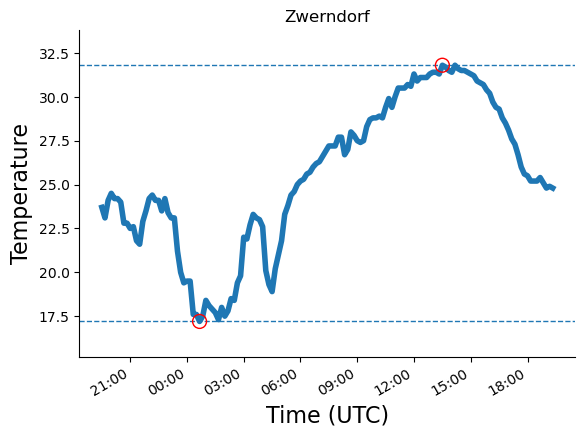

In [65]:
import matplotlib.dates as mdates
test = indexed.sort_values(by=['name', 'time'])

names_unique = test['name'].unique().tolist()
names_unique

for name in names_unique:
    data = test.loc[test['name'] == name]
    # print(data)

fig, axs = plt.subplots(nrows=1, ncols=1)
sns.lineplot(data=data, x='time', y='tl', ax=axs, lw=4)
sns.despine()
fig.autofmt_xdate()
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# xticks = data.index.strftime('%H:%M')
# axs.set_xticklabels(labels=xticks, rotation=45)
axs.set_xlabel('Time (UTC)', fontsize=16)
axs.set_ylabel('Temperature', fontsize=16)
plt.title(name)

# Find max value and index of max value along columns
max = data.max()
idxmax = data.idxmax()
# Find min value and index of max value along columns
min = data.min()
idxmin = data.idxmin()



axs.scatter(idxmax['tl'], max['tl'], s=100, marker='o', lw=1, zorder=3, facecolors='none', edgecolors='r')
axs.scatter(idxmin['tl'], min['tl'], s=100, marker='o', lw=1, zorder=3, facecolors='none', edgecolors='r')

axs.axhline(max['tl'], ls='--', lw=1)
axs.axhline(min['tl'], ls='--', lw=1)

axs.set_ylim([min['tl'] -2, max['tl'] + 2])



In [31]:


m = folium.Map(location=[47.73, 13.48], zoom_start=8, tiles=None)
base_map = folium.FeatureGroup(name='Basemap', overlay=True, control=False)
folium.TileLayer(tiles='https://tile.jawg.io/jawg-dark/{z}/{x}/{y}{r}.png?access-token=MglwGpuT1VUaVc2LSRX042X3krQz6y2cOZfGtNqWg3VMUke6gemUIWz7G1uxPPXP',
                 attr='CartoDB.Voyager', max_zoom=20).add_to(base_map)
base_map.add_to(m)

# Add the date as a title to the map
map_title = individual_dates[-2].strftime("%Y-%m-%d   %H:%M UTC")
title_html = f'<h1 style="position:absolute;z-index:100000;left:40vw;background-color:#eeeee4;" >{map_title}</h1>'
m.get_root().html.add_child(folium.Element(title_html))


COLORS = [
    (lambda x: x > 40, "#EC8989"),
    (lambda x: 35 < x <= 40, "#EA3D09"),
    (lambda x: 30 < x <= 35, "#EA3D09"),
    (lambda x: 25 < x <= 30, "#EA6509"),
    (lambda x: 20 < x <= 25, "#C5C71B"),
    (lambda x: 15 < x <= 20, "#8EF700"),
    (lambda x: 10 < x <= 15, "#07AF02"),
    (lambda x: 5 < x <= 10, "#94EA7F"),
    (lambda x: 0 < x <= 5, "#9cecc8"),
    (lambda x: 0 >= x >= -5, "#18B5DA"),
    (lambda x: -5 > x >= -10, "#1661e8"),
    (lambda x: -10 > x >= -15, "#A375E6"),
    (lambda x: -15 > x >= -20, "#ce8bf0"),
    (lambda x: x < -20, "#EC9CE6"),
]

COLORS_WIND = [
    (lambda x: x >= 100, "#EF06E1"), # purple pizazz
    (lambda x: 80 <= x < 100, "#EF0620"), # torch red
    (lambda x: 60 <= x < 80, "#FB5D04"), # blaze orange
    (lambda x: 40 <= x < 60, "#D8DC0F"), # bitter lemon
    (lambda x: 30 <= x < 40, "#4FBF2A"), # apple
    (lambda x: x < 30, "#000000"), # black
    
    
]



# This picks the color for temperature and tmax, dewpoint and wind
def get_color(x, color_list):
    for predicate, color in color_list:
        if predicate(x):
            return color

    return 'black'



# Add analysis for temperature
fg = folium.FeatureGroup(name="Temperature", control=True, overlay=False).add_to(m)
# marker_cluster = plugins.MarkerCluster(options={'disableClusteringAtZoom':10, 'maxClusterRadius':5, 'singleMarkerMode':False}).add_to(m)

for i in range(np.shape(latest)[0]):
        color = get_color(latest['tl'].iloc[i], COLORS)
        html_str = '<div style="font-size: 14pt; color : ' + color +'">' + str(latest['tl'].iloc[i]) + '</div>'
        p1 = [latest['lat'].iloc[i], latest['lon'].iloc[i]]
        folium.Marker(p1,popup=latest['name'].iloc[i], icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(7,20),
                html= html_str,
                )).add_to(fg)
 
 
# Add analysis for maximum temperature        
fgg = folium.FeatureGroup(name="Tmax", control=True, overlay=False, show=False).add_to(m)

for i in range(np.shape(latest)[0]):
        color = get_color(latest['tlmax'].iloc[i], COLORS)
        html_str = '<div style="font-size: 14pt; color : ' + color +'">' + str(latest['tlmax'].iloc[i]) + '</div>'
        p1 = [latest['lat'].iloc[i], latest['lon'].iloc[i]]
        folium.Marker(p1,popup=latest['name'].iloc[i], icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(7,20),
                html= html_str,
                )).add_to(fgg)
        


# Add analysis for dewpoint temperature        
fggg = folium.FeatureGroup(name="Dewpoint", control=True, overlay=False, show=False).add_to(m)

for i in range(np.shape(latest)[0]):
        color = get_color(latest['td'].iloc[i], COLORS)
        html_str = '<div style="font-size: 14pt; color : ' + color +'">' + str(latest['td'].iloc[i]) + '</div>'
        p1 = [latest['lat'].iloc[i], latest['lon'].iloc[i]]
        folium.Marker(p1,popup=latest['name'].iloc[i], icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(7,20),
                html= html_str,
                )).add_to(fggg)
        



# Add analysis for wind direction of max gust and gust direction
ddg = folium.FeatureGroup(name="Wind direction (max gust) + Max Gust (kmh)", control=True, overlay=False, show=False).add_to(m)

for i in range(np.shape(latest)[0]):
    rotate_str = str(latest['ddx'].iloc[i] + 90)
    color = get_color(latest['ffxkmh'].iloc[i], COLORS_WIND)
    folium.Marker(location=[latest['lat'].iloc[i], latest['lon'].iloc[i]], popup=latest['name'].iloc[i],
                            icon=plugins.BeautifyIcon(icon="fa-solid fa-arrow-right",
                                            border_color='transparent',
                                            background_color='transparent',
                                            border_width=1,
                                            text_color=color,
                                            inner_icon_style='margin:0px;font-size:24px;transform: rotate({0}deg);'.format(rotate_str))).add_to(ddg)

folium.LayerControl().add_to(m)

plugins.Fullscreen(
    position="topright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(m)


# icon = folium.DivIcon(html="17.4")
# folium.Marker([47.0, 15.0], icon=icon).add_to(m)
m.save(os.path.join('simple_popups.html'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27